In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import datetime

## Extract data, merge them by creating a list of actors and their ID in each film

In [5]:
data_path_CMU = 'data/CMU/'
NAMES_MOVIES = ['Wikipedia_movie_ID','Freebase_movie_ID','Movie_name','Movie_release_date','Movie_box_office_revenue','Movie_runtime','Movie_languages','Movie_countries','Movie_genres']
NAMES_CHARACTER = ['Wikipedia_movie_ID','Freebase_movie_ID','Movie_release_date','Character_Name','Actor_DOB','Actor_gender','Actor_height','Actor_ethnicity','Actor_Name','Actor_age_at_movie_release','Freebase_character_actor_map_ID', 'Freebase_character_ID', 'Freebase_actor_ID']

df_CMU_character = pd.read_csv(data_path_CMU+'character.metadata.tsv', sep='\t', names = NAMES_CHARACTER, header = None)
df_CMU_movies = pd.read_csv(data_path_CMU+'movie.metadata.tsv', sep='\t', names = NAMES_MOVIES, header = None)


In [18]:
df_CMU_movies.shape

(81741, 9)

In [20]:
df_UCM_character.shape

(450669, 13)

In [6]:
grouped_actors = df_CMU_character.groupby('Freebase_movie_ID').agg({
    'Actor_Name': list,
    'Freebase_actor_ID': list
}).reset_index()

# Merge the grouped actors data with the movies data
movies_with_actors = df_CMU_movies.merge(grouped_actors, on='Freebase_movie_ID', how='left')

# Rename columns as needed
movies_with_actors.rename(columns={'Actor_name': 'Actors', 'Actor_ID': 'Actor_IDs'}, inplace=True)

In [7]:
movies_with_actors = movies_with_actors.dropna(subset=['Actor_Name'])

In [16]:
movies_with_actors.shape

(64330, 11)

In [14]:
movies_with_actors.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Actor_Name,Freebase_actor_ID
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","[Wanda De Jesus, Natasha Henstridge, Ice Cube,...","[/m/03wcfv7, /m/0346l4, /m/01vw26l, /m/034hyc,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...","[Allen Cutler, Alice Barrett, Rod Britt, Hildy...","[/m/0h8pnlw, /m/034dbm, /m/0lr37gh, /m/0gc9cpb..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","[Frank Krog, Kristin Kajander, Vidar Sandem, A...","[/m/053j7xf, /m/0gct1by, /m/0bwh7d8, /m/04ghdvq]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...","[David Keith, Cathy Moriarty]","[/m/036496, /m/07g60h]"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","[Gudrun Landgrebe, Mathieu Carrière, Hanns Zis...","[/m/09d6hv, /m/06prxs, /m/09k3x_]"


Create a network where the nodes are actors and the edges are the release date of a film in which they acted together

In [19]:
played_together = nx.Graph()

for _, row in movies_with_actors.iterrows():
    actors = row['Actor_Name']
    for i in range(len(actors)):
        for j in range(i + 1, len(actors)):
            if actors[j]!=actors[i]:
                played_together.add_edge(actors[i], actors[j], Realease_date=row['Movie_release_date'])

nan_nodes = [node for node in played_together.nodes if pd.isna(node)] 
played_together.remove_nodes_from(nan_nodes)

Reduce the graph to actors how have more than 500 connection just the test faster

In [60]:
high_degree_nodes = [node for node, degree in played_together.degree() if degree > 500]

subgraph = played_together.subgraph(high_degree_nodes)

print(f"The reduces network contains {subgraph.number_of_nodes()} with a total of {subgraph.number_of_edges()} connections.")

The reduces network contains 375 with a total of 13256 connections.


I will keep it simple but note that we can also filtter by realease date for example:

edges_before_2000 = [
    (u, v) for u, v, attr in played_together.edges(data=True)
    if pd.to_datetime(attr['Realease_date']).year < 2000
]


filtered_graph = played_together.edge_subgraph(edges_before_2000).copy()

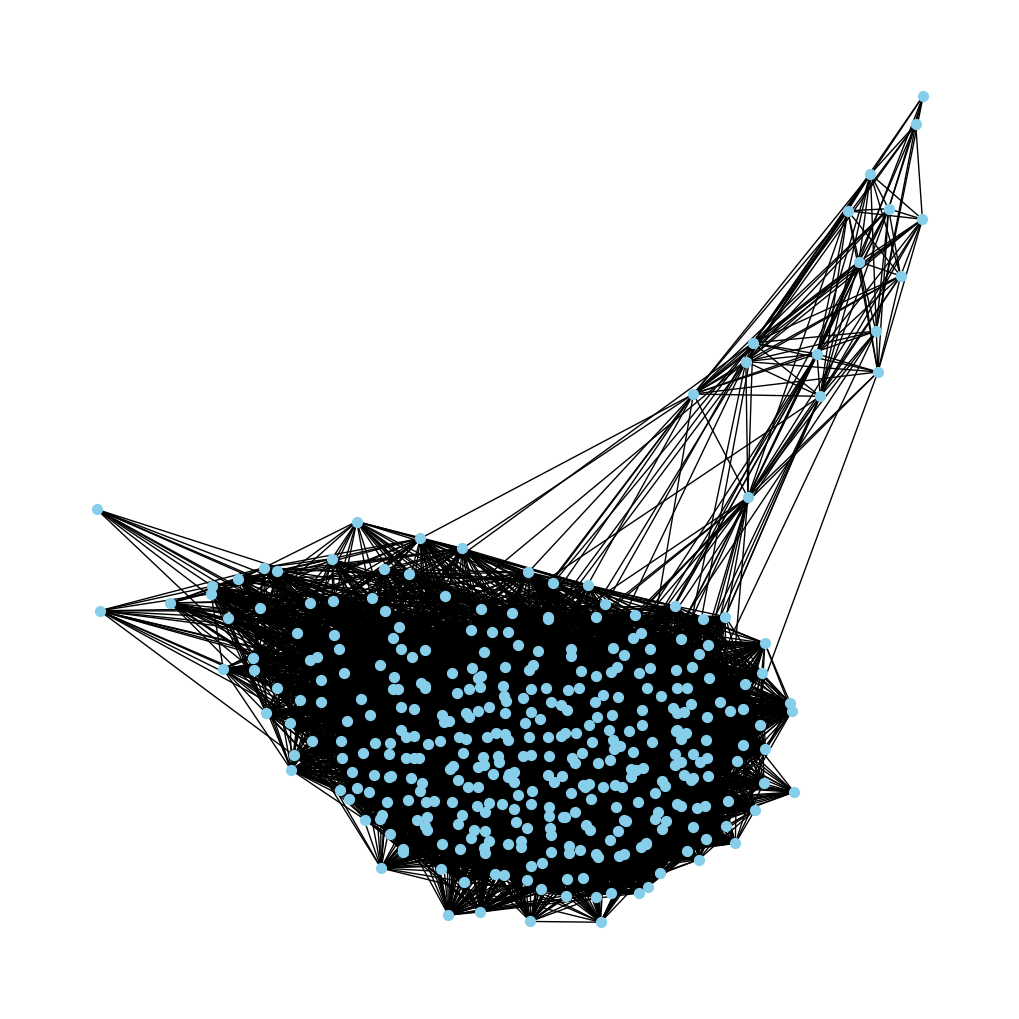

In [34]:
plt.figure(figsize=(10, 10))
nx.draw(subgraph, with_labels=False, node_size=50, node_color="skyblue")
plt.show()

The small network contains 9 with a total of 15 connections.


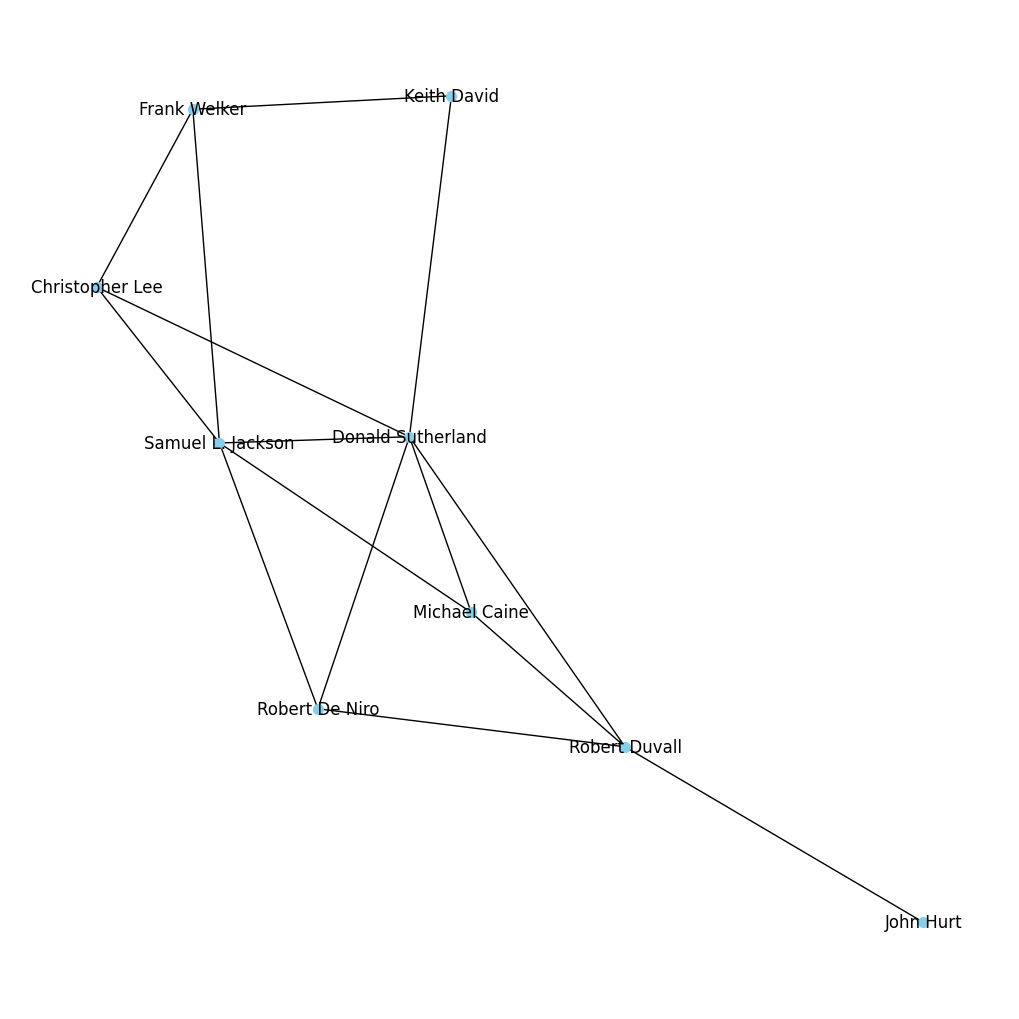

In [42]:
really_high_degree_nodes = [node for node, degree in played_together.degree() if degree > 1000]

small = played_together.subgraph(really_high_degree_nodes)
print(f"The small network contains {small.number_of_nodes()} with a total of {small.number_of_edges()} connections.")
plt.figure(figsize=(10, 10))
nx.draw(small, with_labels=True, node_size=50, node_color="skyblue")
plt.show()

## Informations about the actors

In [98]:
degrees = dict(subgraph.degree())  # The number of connections (collaborations) each actor has.
max(degrees, key=lambda k: degrees[k])

'Brahmanandam'

In [96]:
betweenness_centrality = nx.betweenness_centrality(subgraph) #  Measures an actor's importance in connecting others
max(betweenness_centrality, key=lambda k: betweenness_centrality[k])

'Ben Kingsley'

In [97]:
eigenvector_centrality = nx.eigenvector_centrality(subgraph) # Highlights actors connected to other well-connected actors
max(eigenvector_centrality, key=lambda k: eigenvector_centrality[k])

'Steve Buscemi'

In [102]:
neighbors = list(subgraph.neighbors('Brahmanandam')) # Find which actors have worked with a specific actor.
print(neighbors)

['Prakash Raj', 'Nassar', 'Paresh Rawal', 'Anupam Kher', 'Jackie Shroff', 'Gulshan Grover']


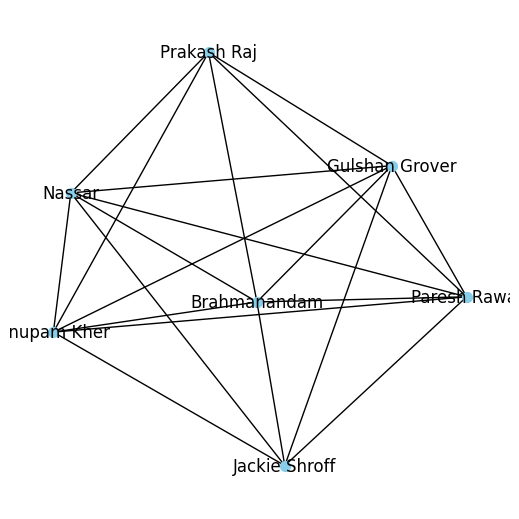

In [110]:
ego_graph = nx.ego_graph(subgraph, 'Brahmanandam', radius=1) # Subgraph showing all connections within a certain "distance" from a given actor
plt.figure(figsize=(5, 5))
nx.draw(ego_graph, with_labels=True, node_size=50, node_color="skyblue")
plt.show()

## Informations about clusters

In [122]:
clustering_coefficients = nx.clustering(subgraph) #Measures the tendency of an actor’s connections to also be connected.
#the clustering of a node is the fraction of possible triangles through that node that exist
max(clustering_coefficients, key=lambda k: clustering_coefficients[k])

'Sanjay Dutt'

In [128]:
#Using algorithms like Girvan-Newman or Louvain to find clusters of actors who frequently work together.
from networkx.algorithms.community import greedy_modularity_communities
communities = list(greedy_modularity_communities(subgraph))
print(communities[2])

frozenset({'Bruce Dern', 'Ned Beatty', 'Jack Nicholson', 'Scott Glenn', 'Martin Sheen', 'Stockard Channing', 'Karen Black', 'Geoffrey Lewis'})


The subgraph has density: 0.27009068869533986


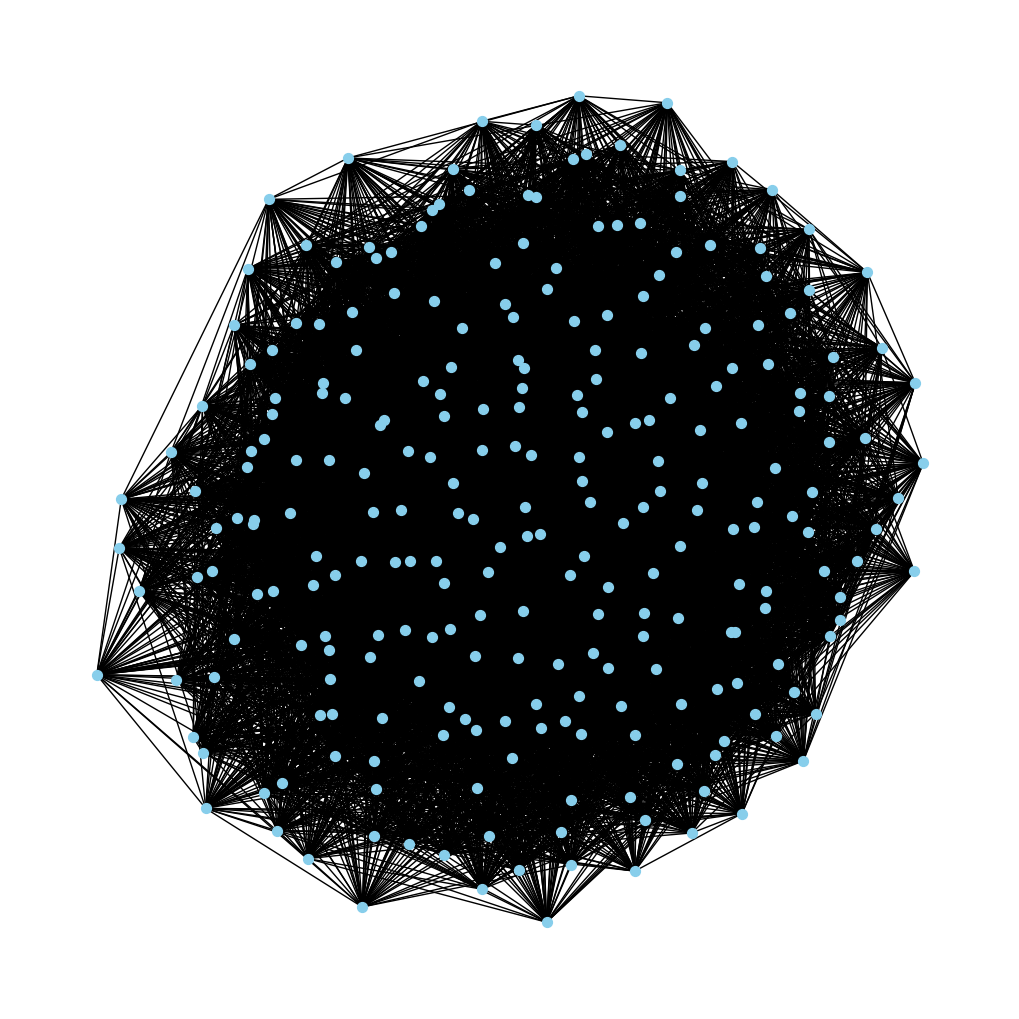

In [118]:
k_core = nx.k_core(subgraph, k=50) #Extract the subgraph where each actor has at least k collaborations WHITIN the subgraph
density_k_core = nx.density(k_core) # Measure of how many connections exist compared to the maximum possible.

print(f"The subgraph has density: {density_k_core}")
plt.figure(figsize=(10, 10))
nx.draw(k_core, with_labels=False, node_size=50, node_color="skyblue")
plt.show()

[['Ellen Burstyn', 'Harry Dean Stanton', 'Clint Eastwood', 'Max von Sydow', 'Donald Sutherland', 'Cary Grant', 'Gregory Peck', 'Kevin McCarthy', 'Kurt Russell', 'Faye Dunaway', 'Elliott Gould', 'Donald Pleasence', 'Michael Ironside', 'Ray Milland', 'Jeff Goldblum', 'Ian Holm', 'Carol Kane', 'Rutger Hauer', 'Dustin Hoffman', 'Alan Arkin', 'Keith David', 'Sigourney Weaver']]


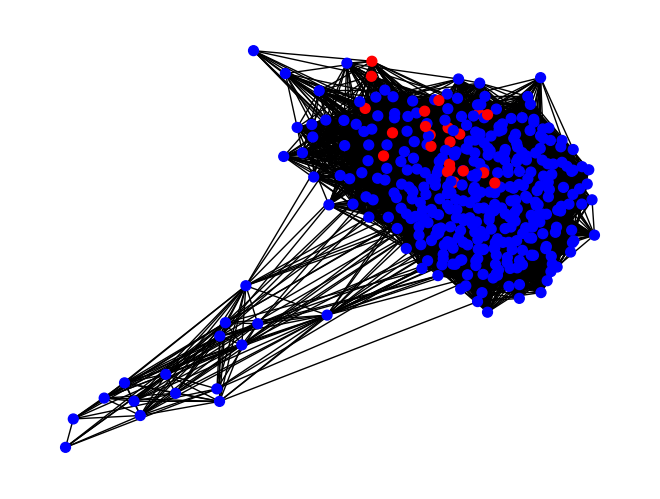

In [154]:
cliques = list(nx.find_cliques(subgraph))


color_map = {node: 'blue' for node in subgraph.nodes()}  

max_clique_size = max(len(clique) for clique in cliques)
largest_cliques = [clique for clique in cliques if len(clique) == max_clique_size]

for node in largest_cliques[0]:
    color_map[node] = 'red'


colors = [color_map[node] for node in subgraph.nodes()]
nx.draw(subgraph, node_color=colors, node_size=50, with_labels=False)
plt.show()

## How to create a graph where the wiegths of the edges are the number of times they played together

In [161]:
import time
start = time.time()

played_together_Multi = nx.MultiGraph()

for _, row in movies_with_actors.iterrows():
    actors = row['Actor_Name']
    for i in range(len(actors)):
        for j in range(i + 1, len(actors)):
            if actors[j]!=actors[i]:
                played_together_Multi.add_edge(actors[i], actors[j], Realease_date=row['Movie_release_date'])

nan_nodes = [node for node in played_together_Multi.nodes if pd.isna(node)] 
played_together_Multi.remove_nodes_from(nan_nodes)
print(f"Finish creating the Multi graph in {time.time()-start}")


start = time.time()
#Convert MultiGraph to Graph and sum the edges

played_together_weighted = nx.Graph()
for u, v, data in played_together_Multi.edges(data=True):
    if played_together_weighted.has_edge(u, v):
        # Increment the weight if edge already exists
        played_together_weighted[u][v]["weight"] += 1
    else:
        # Otherwise, create the edge with weight 1
        played_together_weighted.add_edge(u, v, weight=1)
        
print(f"Finish creating the Weighted graph in {time.time()-start}")

Finish creating the Multi graph in 39.52254009246826
Finish creating the Weighted graph in 13.134217977523804


In [163]:
high_degree_nodes = [node for node, degree in played_together_weighted.degree() if degree > 500]

subgraph_weighted = played_together_weighted.subgraph(high_degree_nodes)

print(f"The reduces network contains {subgraph_weighted.number_of_nodes()} with a total of {subgraph_weighted.number_of_edges()} connections.")

The reduces network contains 375 with a total of 13256 connections.


In [171]:
clustering_coefficient_weighted = nx.clustering(subgraph_weighted, weight="weight")
max(clustering_coefficient_weighted, key=lambda k: clustering_coefficient_weighted[k])

'Shakti Kapoor'